<h1> Dynamic Topic Modelling Using MNF (see Greene) </h1>

In [9]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt

from itertools import islice
from scipy.linalg import block_diag
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel


# Remove warnings
import warnings
warnings.filterwarnings("ignore")


In [5]:
##############################################################################################################################################
# Set all functions for the dynamic topics modellings

# function to create a new dictionary and corpus
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus


# function to pre-process the data: compute tfidf
def preprocess(df, stopwords):
    # Append all the final tokens
    text = []
    docs = df['list_final_tokens']
    
    for abstract in docs:
        text.append(' '.join(abstract))
        
    # Create the term-document matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, lowercase=False, stop_words=stop_wds)
    tf_idf = tfidf_vectorizer.fit_transform(text)
            
    return (tf_idf, tfidf_vectorizer)


# function to list topic (modified function from https://nlpforhackers.io/topic-modeling/)
def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.  
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1: 
            # check if the vectorized has an attribute get_features_names. if not vectorized contains terms hasattr('abc', 'lower')
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[::-1]])
        else:
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words



# function to solve the nmf (modified from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)
def nmf_models(doc_term_matrix, n_topics, vectorizer, rand_start):
    """
    Compute NMF model, save topics list for coherence calc
    Parameters:
    ----------
    doc_term_matrix: document-terms matrix
    n_topics: list of topics number
    vectorizer: vector of terms
    rand_start: random seed
    """
    
    nmf_time = []
    topics_list = []
    W_list = []
    H_list = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        nmf_time.append(t2-t1)
        #print(f"  Model time: {t2-t1}", flush=True)
        
        # create list of topics
        topics = list_topics(nmf_model.components_, vectorizer, top_n=10)
        topics_list.append(topics)
        
        # output completion message
        i = i+1
        #print('Number of topics =', num_topics, "complete.", flush=True)
        
        # save the matrix W and H
        W = nmf_model.fit_transform(doc_term_matrix)
        W_list.append(W)
        H = nmf_model.components_
        
        # truncate the H matrix: set the weight of the non top n words to zero
        #top_n = 10
        #for idx, topic in enumerate(H):
        #    thresold = numpy.nanmin(topic[topic.argsort()[:-top_n-1:-1]])
        #    topic[topic<thresold]=0  
        H_list.append(H)

    return nmf_time, topics_list, W_list, H_list


# function to solve the first stage of the dynamic nmf
def first_stage(path, year, n_topics, dictionary, docs):
    """
    Solve a dynamic nmf for each fiscal year
    Parameters:
    ----------
    path: location of term-document matrix
    year: list of fiscal year
    n_topics: list of topics number
    dictionary: dictionary of terms
    docs: corpus
    """
    batch = 7
    
    windows_coherence = []
    windows_topic_list = []
    windows_topic = []
    windows_W = []
    windows_H = []
    windows_terms = []
    
    # Run the dynamic nmf for each fiscal year
    for y in year:
        # Load the document-term matrix
        (tf_idf,tfidf_vectorizer,df) = joblib.load( path+str(y)+'.pkl' )
        
        # save all the term
        #terms = tfidf_vectorizer.get_feature_names()
    
        # Solve an nmf model for a given range of topics
        (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=tf_idf, n_topics=n_topics, vectorizer=tfidf_vectorizer, rand_start = (batch)*len(n_topics))
        
        # Compute the coherence for each topics
        coherence = []
    
        for t in range(0,len(n_topics)):
            window_term_rankings = topics_list[t]
            cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
            coherence.append(cm.get_coherence())
    
        # find the topics that maximize the coherence
        max_coherence = numpy.nanmax(coherence)
        index = coherence.index(max_coherence)
        topic_select = n_topics[index]
        fy_topic_list = topics_list[index]
        W = W_list[index]
        H = H_list[index]
       
        # For the best model (that maximize the coherence) transform the matrix H (for each topic set the weigth of non top n terms to 0)
        # select all the unique terms of topics
        topic_terms = list(set(sum(fy_topic_list,[])))
        
        # select the index of terms that appear in the topics and subset the matrix H to those terms
        if hasattr(tfidf_vectorizer, 'get_feature_names'):
            terms = tfidf_vectorizer.get_feature_names()
        else:
            terms = tfidf_vectorizer
            
        indcol = [terms.index(i) for i in topic_terms]
        subH = H[:,indcol]
        
        # For each topic (rows) set the weigth of terms that are not listed the topic to 0.
        for i,j in enumerate(subH):
            # by row find the index of top_n terms
            indtopic = [topic_terms.index(p) for p in fy_topic_list[i]]
            notop = [k for k in range(len(topic_terms)) if k not in indtopic]
            j[notop]=0

         # append the result
        windows_coherence.append(max_coherence)
        windows_topic_list.append(fy_topic_list)
        windows_topic.append(topic_select)
        windows_W.append(W)
        windows_H.append(subH)
        windows_terms.append(topic_terms)
        print('--- windows topic '+str(y)+' solve ---')
        
    print('--- Dynamic nmf: first stage clear ---')
        
    return windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms


# Create a new document term matrix using the topic distribution
def create_matrix(windows_H, windows_terms):
    """
    Create the topic-term matrix from all window topics that have been added so far.
    Parameters:
    ----------
    windows_H: windiws topic distribution of top n words
    windows_terms: windows terms used for each fiscal year
    """
    # Set a list of all terms unique terms across windows (all_terms) and the combine windows terms (all_windows_terms)
    all_windows_terms = sum(windows_terms,[])
    
    # Create a block diagonal matrix of all topics: the number of rows is the same as the length of list_terms
    M = block_diag(*windows_H)
    
    # Identify duplicated terms (columns) and sum them
    # The fastest way is to transform M into data frame with
    dfM = pd.DataFrame(data = M, columns=all_windows_terms).groupby(level=0, axis=1).sum()
    
    # Transform back the dataframe to matrix and get the variable names (in the order in the matrix) as the final all terms
    M_concat = dfM.to_numpy()
    all_terms = list(dfM.columns)
    
    print('--- New document-terms have been created ---')
    
    return M_concat, all_terms


# function to solve the second stage of the dynamic nmf
def second_stage(windows_H, windows_terms, n_topics):
    """
    Build a new document term matrix and run a new nmf model
    Parameters:
    ----------
    windows_H: windiws topic distribution of top n words
    windows_terms: windows terms used for each fiscal year
    n_topics: list of topics number for the second stage
    """
    batch = 7
    
    # Build the new document-term matrix
    (M, all_terms) = create_matrix(windows_H, windows_terms)
    
    # Run a second nmf model
    (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=M, n_topics=n_topics, vectorizer=all_terms, rand_start = (batch)*len(n_topics))
    
    print('--- Dynamic nmf: second stage clear ---')
    
    return M, all_terms, topics_list, W_list,H_list


# Track the dynamic of a given topic (option topic)
def track_dynamic(topic,W,windows_topic_list):
    """
    Link topics in the first stage with topic in second stage using the matrix W
    Parameters:
    ----------
    topic: topic to track the dynamic
    W: weigth matrix from the second stage
    windows_topic_list: topic list from the first stage
    """
    # For each topic from the first stage (rows) find the topic in the second stage (columns) with the higher weight
    topic_second = []
    for i, topic_first in enumerate(W):
        topic_second.append(topic_first.argmax())
        
    # Split topics classification in the first by year
    it = iter(topic_second)
    topic_first_year = [[next(it) for _ in range(size)] for size in windows_topic]
    
    # For each topic, identify the correspondance for each year
    dynamic_topic_list = []
    for y in range(0, len(year)):
        topic_year = [i for i, e in enumerate(topic_first_year[y]) if e == topic]
        dynamic_topic_list.append(topic_year)

    # Compute the list of list of topics (list of year and list of main topic)
    dynamic_topic = []
    for y in range(0, len(year)):
        dynamic_list = dynamic_topic_list[y]
        fy_topic = [windows_topic_list[y][dynamic_list[i]] for i in range(0,len(dynamic_list))] 
        dynamic_topic.append(fy_topic)
        
    # Print the result in a dataframe
    topic_print = []
    names = []

    # print the dynamic topic
    for y in range(0,len(year)):
        for t in range(0,len(dynamic_topic[y])):
            topic_print.append(dynamic_topic[y][t])
            names.append('Year_'+str(year[y])+'_'+str(t))
        
    df = pd.DataFrame (topic_print).transpose()
    df.columns = names
    
    return df, dynamic_topic_list


<h2> 1. Download the data </h2>

In [2]:
##########################################################################################################################################################
# Load the dataset 
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.head()

# Create a list of tokens 
df["list_final_tokens"] = df["final_tokens"].str.split(' ').tolist()
year = df['FY'].unique()


<h3> 1.1. Pre-processing </h3>

In [4]:
##########################################################################################################################################################
# Preprocessing

# Create a new dataset for each fiscal year
for y in year:
    df_subset = df[df['FY']==y]
    
    # save the pickle file
    pickle.dump(df_subset, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Data/FR_'+str(year)+'.pkl','wb'))


# Create the term-document matrix tfidf for each pkl file
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

for y in year:
    # Load the sample for a given year
    fw = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Data/FR_'+str(year)+'.pkl', 'rb')
    dfw = pickle.load(fw)
    fw.close()
            
    # Pre-processing the pkl file
    (tf_idf, tfidf_vectorizer) = preprocess(dfw, stop_wds)
    
    # Save the term-document matrix
    joblib.dump((tf_idf,tfidf_vectorizer,df), '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Term_docs_'+str(year)+'.pkl' )

    

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,list_final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,...,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,"[project, explore, game, base, metaphor, enhan..."
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,...,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,"[institution, franklin, institute, science, mu..."
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,...,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,"[program, include, small, group, conversation,..."
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,...,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,"[partnership, american, chemical, society, acs..."
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,...,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,"[center, molecular, interfacing, cmi, enable, ..."


In [6]:
# build the dictionary id2word
docs = df["list_final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

<h3> 2. Step 1: Window Topic Modeling </h3>

In [7]:
###########################################################################################################################################################
# Run a dynamic topic model

# First stage : use the same list of number of topics for both first and second stage
path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Term_docs_'
n_topics = list(range(20,61,5))

(windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms) = first_stage(path, year, n_topics, dictionary, docs)


AttributeError: 'list' object has no attribute 'get_feature_names'

In [12]:
path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Term_docs_'
y= year[0]
(tf_idf,tfidf_vectorizer,df) = joblib.load( path+str(y)+'.pkl' )

In [13]:
tfidf_vectorizer.get_feature_names()

AttributeError: 'list' object has no attribute 'get_feature_names'

In [14]:
tfidf_vectorizer

['00001as',
 '0000title',
 '0001',
 '0001000travelattendance',
 '00015_breast',
 '0001_0002',
 '0001_0004',
 '0001four',
 '0001immune',
 '0001mg',
 '0001title',
 '0002',
 '00020_diethylstilbestrol',
 '0002_0003',
 '0002title',
 '0003',
 '0003core',
 '0004',
 '00043_umbilical',
 '0004stress',
 '0004under',
 '0005',
 '0005_006',
 '0005and',
 '0005the',
 '0006',
 '0006in',
 '0007',
 '0008',
 '0008_0009',
 '0009',
 '0010',
 '0010computation',
 '0011',
 '0012',
 '0013',
 '0014',
 '0015',
 '0016',
 '0017',
 '0018',
 '001852a',
 '001_01',
 '001_03',
 '001_10',
 '001_cgy',
 '001_m_cacl2',
 '001_ppm',
 '001c',
 '001mevall',
 '001title',
 '001um',
 '0020',
 '0021',
 '0023',
 '0024',
 '0025',
 '0026',
 '0026the',
 '0028',
 '0029',
 '002_00d',
 '002_nett',
 '002the',
 '002which',
 '0032',
 '0033',
 '0034',
 '0035',
 '0036',
 '0038',
 '0038urn',
 '003_00d',
 '003_mg',
 '003_ncmhd',
 '00400_multi',
 '0044',
 '0044a',
 '0044core',
 '0046',
 '0047',
 '0048',
 '0049',
 '004_hz',
 '004mg',
 '004x004x002

In [ ]:
# Compute the coherence for topics in each topic windows
krange = list(range(20,101,5))
#skip = [[37, 2008], [39, 2008], [45, 2008], [46, 2008], [24, 2013],[27, 2013]]
skip = []
time_topic_coherence = []

for t in time:
    time_coherence=[]
    
    for k in krange:
        s = int(k)
        d = int(t)
        search = [s,d]
        
        #print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k%s.pkl' %(d,s))
        window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_%d_windowtopics_k%s.pkl' %(d,s))
        window_k = len(window_res[2])
        window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
        # compute the coherence
        try:
            cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
            time_coherence.append(cm.get_coherence())
        except:
            cm=0
            time_coherence.append(cm)
            pass
    time_topic_coherence.append(time_coherence)
    print('---- coherence computation ended ------')
    

In [ ]:
# Select the number of topics that maximise the coherence in the first stage
topic_windows = []
coherence_windows = []
for t in range(0,len(time)):
    coherence = time_topic_coherence[t]
    max_coherence = numpy.nanmax(coherence)
    index = coherence.index(max_coherence)
    topic_windows.append(krange[index])
    coherence_windows.append(max_coherence)

print('The number of topics for each window period is:', topic_windows)

In [ ]:
# plot the maximimum coherence over the fiscal year
coherence_windows_ts = pd.Series(coherence_windows, index =time)
plt.plot(coherence_windows_ts)
plt.title('Topic coherence in the DTN-NMF at each Fiscal year')
plt.xlabel("Fiscal year")
plt.ylabel("Topic coherence")
plt.savefig('Coherence_first_step.png')

<h2> Dynamic Topic Modeling </h2>

In [12]:
# Solve the dynamic topic modelling using the optimal number of topic in the first step
!python find-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k35.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k10.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k10.pkl -k 10,40 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out


Using random seed 1000
- Processing individual time window topic models ...
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded 30 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded 15 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl
Loaded 20 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl
Loaded 25 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl
Loaded 20 time window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl
Loaded 25 time wind

In [13]:
# Find the best dynamic topic model (2nd stage)
topic_coherence = []

for k in krange:
    s = int(k)
    #print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_k = len(window_res[2])
    window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
    # compute the coherence
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', processes=30)
    topic_coherence.append(cm.get_coherence())

# Choose the best dynamic topic model (maximises the 2nd step coherence)
max_coherence = numpy.nanmax(topic_coherence)
index = topic_coherence.index(max_coherence)
print('The best dynamic topic model is: ', krange[index])

The best dynamic topic model is:  20


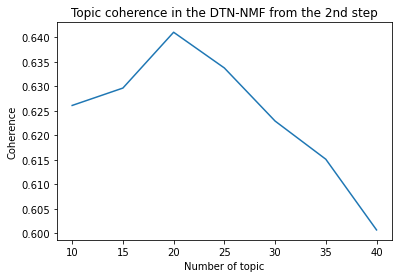

In [14]:
coherence_ts = pd.Series(topic_coherence, index =krange)
plt.plot(coherence_ts)
plt.title('Topic coherence in the DTN-NMF from the 2nd step')
plt.xlabel("Number of topic")
plt.ylabel("Coherence")
plt.savefig('Coherence_second_step.png')

In [15]:
# Display the topic list from the NMF-DTM
!python display-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl

- Loaded model with 20 topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl
Top 10 terms for 20 topics:
+------+-----------+-----------+-------------+---------------------+-----------+------------+------------+------------+
| Rank | D01       | D02       | D03         | D04                 | D05       | D06        | D07        | D08        |
+------+-----------+-----------+-------------+---------------------+-----------+------------+------------+------------+
|    1 | virus     | influenza | mouse       | mers_cov            | fusion    | vaccine    | ace2       | immune     |
|    2 | host      | virus     | cell        | rbd                 | peptide   | vector     | receptor   | polygenic  |
|    3 | factor    | swine     | response    | bind                | entry     | attenuate  | sar_cov    | regulate   |
|    4 | species   | pandemic  | aged        | receptor            | protein   | virus      | epithelial | tra

In [48]:
# Track the dynamic
# Displays the dynamic of topic 3 (specify the -d 3 at the end of the line)
!python track-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k35.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k10.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k15.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k20.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k10.pkl -d 7


Loaded model with 20 dynamic topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded model with 15 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k15.pkl
Loaded model with 20 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k20.pkl
Loaded model with 25 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k25.pkl
Loaded model with 20 window topics from /project/biocomplexity/sdad/projects_d

In [17]:
# Topic assignment and duplicate assignment
dynamic_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k20.pkl')
dynamic_k = len(dynamic_res[2])

# Build the topic-words and limits on the top 10 words
dynamic_term_rankings = unsupervised.rankings.truncate_term_rankings( dynamic_res[2], 10 )

# Comment: All topic from the first step have 
#          This have an implication when computing the coherence
# Create a map of window topic label -> dynamic topic
assigned_window_map = {}
dynamic_partition = dynamic_res[3]
for idx, window_topic_label in enumerate(dynamic_res[0]):
    assigned_window_map[window_topic_label] = dynamic_partition[idx]
    
# Print the association
assigned_window_map

{'Term_docs_2008_01': 16,
 'Term_docs_2008_02': 1,
 'Term_docs_2008_03': 2,
 'Term_docs_2008_04': 8,
 'Term_docs_2008_05': 5,
 'Term_docs_2008_06': 8,
 'Term_docs_2008_07': 1,
 'Term_docs_2008_08': 6,
 'Term_docs_2008_09': 19,
 'Term_docs_2008_10': 9,
 'Term_docs_2008_11': 9,
 'Term_docs_2008_12': 14,
 'Term_docs_2008_13': 14,
 'Term_docs_2008_14': 17,
 'Term_docs_2008_15': 16,
 'Term_docs_2008_16': 10,
 'Term_docs_2008_17': 1,
 'Term_docs_2008_18': 19,
 'Term_docs_2008_19': 15,
 'Term_docs_2008_20': 0,
 'Term_docs_2008_21': 19,
 'Term_docs_2008_22': 4,
 'Term_docs_2008_23': 14,
 'Term_docs_2008_24': 0,
 'Term_docs_2008_25': 8,
 'Term_docs_2008_26': 18,
 'Term_docs_2008_27': 0,
 'Term_docs_2008_28': 19,
 'Term_docs_2008_29': 18,
 'Term_docs_2008_30': 11,
 'Term_docs_2009_01': 0,
 'Term_docs_2009_02': 5,
 'Term_docs_2009_03': 8,
 'Term_docs_2009_04': 17,
 'Term_docs_2009_05': 14,
 'Term_docs_2009_06': 1,
 'Term_docs_2009_07': 11,
 'Term_docs_2009_08': 4,
 'Term_docs_2009_09': 16,
 'Term

In [18]:
# Track duplicates assignment
assign_val = list(assigned_window_map.values())
i = 0
kupd = []

for chunk in topic_windows:
    kupd.append(assign_val[i:i+chunk])
    i += chunk
    
# Show the deduplicates assignment
dedup = [len(set(kupd[i])) for i in range(0,len(time))]
print ('Number of non-duplicated assgniment in topics per windows :', dedup)
print ('Number of duplicated assigment in topics per windows :', list(numpy.array(topic_windows) - numpy.array(dedup)))

Number of non-duplicated assgniment in topics per windows : [16, 11, 14, 16, 16, 17, 18, 9, 15, 12, 14, 10]
Number of duplicated assigment in topics per windows : [14, 4, 6, 9, 4, 8, 17, 1, 5, 3, 6, 0]


<h2> 3. Change in topics </h2>

In [64]:
# Plot the topics change in terms of distribution
dynamic_term_rankings

[['virus',
  'host',
  'factor',
  'species',
  'viral',
  'new',
  'family',
  'dengue',
  'infection',
  'crop'],
 ['influenza',
  'virus',
  'swine',
  'pandemic',
  '1918',
  'bird',
  'iav',
  'ha',
  'human',
  'strain'],
 ['mouse',
  'cell',
  'response',
  'aged',
  'disease',
  'severe',
  'cns',
  'aim',
  'infection',
  'respiratory'],
 ['mers_cov',
  'rbd',
  'bind',
  'receptor',
  'vaccine',
  'subunit',
  'protein',
  'neutralize_antibody',
  'spike',
  'dpp4'],
 ['fusion',
  'peptide',
  'entry',
  'protein',
  'membrane',
  'receptor',
  'class',
  'dv',
  'inhibitor',
  'spike'],
 ['vaccine',
  'vector',
  'attenuate',
  'virus',
  'candidate',
  'live',
  'ndv',
  'develop',
  'safe',
  'protective'],
 ['ace2',
  'receptor',
  'sar_cov',
  'epithelial',
  'entry',
  'nl63_cov',
  'lung',
  'sar',
  'nl63',
  'pulmonary'],
 ['immune',
  'polygenic',
  'regulate',
  'trait',
  'response',
  'protective',
  'immunity',
  'phenotype',
  'kinetic',
  'diverse'],
 ['inhibi

<h2> 4. Solve for assigment issue </h2>

In [ ]:
# Create a windows-topics by applying NMF on each tfidf pkl file
# Number of topic per windows k= 30
!python find-window-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/*.pkl -k 30,30 -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out

In [42]:
# Count the number of distinct topics assignment by windows
kupd = []
assign_val = list(assigned_window_map.values())
for k in range(0,len(time)-1):
    kupd.append(len(set(assign_val[(30*k):(30*(k+1)-1)])))



TypeError: 'int' object is not iterable

In [ ]:
# Run a new dynamic topic model with this list at the first step

[30, 12, 24, 17, 21, 25, 16, 11, 19, 14, 23, 10]

In [220]:
topic_coherence = []

for k in krange:
    s = int(k)
    print('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_res = unsupervised.nmf.load_nmf_results('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k%s.pkl' %s)
    window_k = len(window_res[2])
    window_term_rankings = unsupervised.rankings.truncate_term_rankings( window_res[2], 10 )
    
    # compute the coherence
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', processes=30)
    topic_coherence.append(cm.get_coherence())
    

/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k10.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k11.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k12.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k13.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k14.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k15.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k16.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k17.pkl
/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k18.pkl
/project/biocomplexity/sdad/projects_

Text(0, 0.5, 'Coherence')

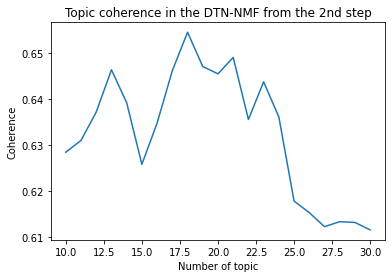

In [221]:
coherence_tm = pd.Series(time_coherence, index =krange)
serie = coherence_tm.plot()
plt.title('Topic coherence in the DTN-NMF from the 2nd step')
plt.xlabel("Number of topic")
plt.ylabel("Coherence")

In [222]:
# Choose the best dynamic topic model (maximises the 2nd step coherence)
max_coherence = numpy.nanmax(time_coherence)
index = time_coherence.index(max_coherence)
krange[index]

18

In [223]:
# Display the topic list from the NMF-DTM
!python display-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k18.pkl

- Loaded model with 18 topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k18.pkl
Top 10 terms for 18 topics:
+------+--------------+-----------+-----------+-----------+---------------------+------------+--------------+------------+
| Rank | D01          | D02       | D03       | D04       | D05                 | D06        | D07          | D08        |
+------+--------------+-----------+-----------+-----------+---------------------+------------+--------------+------------+
|    1 | rna          | influenza | cell      | vaccine   | mers_cov            | immune     | mosquito     | ace2       |
|    2 | replication  | virus     | mouse     | vector    | vaccine             | polygenic  | transmission | receptor   |
|    3 | protein      | swine     | response  | attenuate | rbd                 | regulate   | diversity    | airway     |
|    4 | viral        | pandemic  | aged      | core      | bind                | trait     

In [224]:
# Track the dynamic
# Displays the dynamic of topic 3 (specify the -d 3 at the end of the line)
!python track-dynamic-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k18.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k12.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k24.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k17.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2012_windowtopics_k21.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2013_windowtopics_k25.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2014_windowtopics_k16.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2015_windowtopics_k11.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2016_windowtopics_k19.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2017_windowtopics_k14.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2018_windowtopics_k23.pkl /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2019_windowtopics_k10.pkl -d 12


Loaded model with 18 dynamic topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/dynamictopics_k18.pkl
Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Loaded model with 30 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2008_windowtopics_k30.pkl
Loaded model with 12 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2009_windowtopics_k12.pkl
Loaded model with 24 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2010_windowtopics_k24.pkl
Loaded model with 17 window topics from /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out/Term_docs_2011_windowtopics_k17.pkl
Loaded model with 21 window topics from /project/biocomplexity/sdad/projects_d

{'Term_docs_2008_01': 0,
 'Term_docs_2008_02': 1,
 'Term_docs_2008_03': 14,
 'Term_docs_2008_04': 8,
 'Term_docs_2008_05': 3,
 'Term_docs_2008_06': 8,
 'Term_docs_2008_07': 1,
 'Term_docs_2008_08': 7,
 'Term_docs_2008_09': 14,
 'Term_docs_2008_10': 17,
 'Term_docs_2008_11': 17,
 'Term_docs_2008_12': 15,
 'Term_docs_2008_13': 15,
 'Term_docs_2008_14': 2,
 'Term_docs_2008_15': 14,
 'Term_docs_2008_16': 6,
 'Term_docs_2008_17': 1,
 'Term_docs_2008_18': 14,
 'Term_docs_2008_19': 16,
 'Term_docs_2008_20': 10,
 'Term_docs_2008_21': 18,
 'Term_docs_2008_22': 9,
 'Term_docs_2008_23': 15,
 'Term_docs_2008_24': 10,
 'Term_docs_2008_25': 8,
 'Term_docs_2008_26': 18,
 'Term_docs_2008_27': 10,
 'Term_docs_2008_28': 14,
 'Term_docs_2008_29': 18,
 'Term_docs_2008_30': 11,
 'Term_docs_2009_01': 10,
 'Term_docs_2009_02': 3,
 'Term_docs_2009_03': 8,
 'Term_docs_2009_04': 11,
 'Term_docs_2009_05': 10,
 'Term_docs_2009_06': 1,
 'Term_docs_2009_07': 7,
 'Term_docs_2009_08': 9,
 'Term_docs_2009_09': 17,
 'T

[30, 12, 24, 17, 21, 25, 16, 11, 19, 14, 23, 10]

[15, 10, 14, 11, 16, 16, 13, 10, 13, 11, 13, 9]

<h2> 3. Find the best topic model </h2>

In [28]:
# Run the NMF dynamic for many number of topics
! location = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/'; ECHO location 
!python find-window-topics.py *.pkl -k topic,topic -o location/out
    

/bin/bash: location: command not found
/bin/bash: ECHO: command not found
Traceback (most recent call last):
  File "find-window-topics.py", line 151, in <module>
    main()
  File "find-window-topics.py", line 42, in main
    kmin = int(kparts[0])
ValueError: invalid literal for int() with base 10: 'topic'


In [36]:
#!python location = /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/
! export TOPIC='20,20'
 

In [48]:
!export TOPIC=20; echo $TOPIC

SyntaxError: invalid syntax (<ipython-input-48-93426aa3e565>, line 2)

In [40]:
! export TOPIC=20,30


Traceback (most recent call last):
  File "find-window-topics.py", line 151, in <module>
    main()
  File "find-window-topics.py", line 38, in main
    kmin = int(options.krange)
ValueError: invalid literal for int() with base 10: '-o'


In [49]:
import find-dynamic-topics

SyntaxError: invalid syntax (<ipython-input-49-6f9b42384d3e>, line 1)

In [50]:
sys.path.insert(0, '/home/yhu2bk/Github/publicrd/src/Dynamic_Topic_Modelling/NMF/')
import find-dynamic-topics

SyntaxError: invalid syntax (<ipython-input-50-1ecaf65e9e21>, line 2)

In [ ]:
python find-window-topics.py /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/*.pkl -k $TOPIC -o /project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/out 

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]